# Temporal Kolmogorov-Arnold Networks (TKAN) for Solar Power Prediction

**Author:** Clyde Watts  
**Lecturer:** Andrew Beaty  
**Date:** 2025-01-11

## Overview

This notebook implements **Temporal KAN (TKAN)** using **PyTorch** (not Keras/TensorFlow) for solar power prediction.

### Key Features:
- **Pure PyTorch implementation** - No Keras or TensorFlow
- **Temporal encoding** - Explicit use of DateTime column features (hour, day_of_week, day_of_year, month)
- **Sinusoidal temporal embeddings** - Similar to positional encoding in Transformers
- **Learnable activation functions** - KAN's signature feature with RBF kernels
- **Regularization** - L1 regularization on learnable weights

### Comparison with Efficient KAN:
- Efficient KAN treats time implicitly through features
- TKAN explicitly encodes temporal patterns from DateTime column
- TKAN uses PyTorch (this notebook), Efficient KAN also uses PyTorch
- Both use learnable univariate functions (KAN's core concept)


## Imports and Setup

In [198]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import os
import datetime

# Import our TKAN implementation
from tkan_implementation import TKAN, extract_temporal_features

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


## Configuration and Paths

In [199]:
# Directory paths
NOTEBOOK_DIR = os.getcwd()
DATA_DIR = os.path.join(NOTEBOOK_DIR, 'data')
TRAIN_DATA_DIR = os.path.join(DATA_DIR, 'training_data')
MODEL_DIR = os.path.join(NOTEBOOK_DIR, 'model')
RESULTS_DIR = os.path.join(NOTEBOOK_DIR, 'results')

# Create directories if they don't exist
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)

# Solar configuration
NUM_PANELS = 19
TOTAL_CAPACITY = 8360  # Watts
hourly_nighlty_threshold = 50

# Target column
target_col = 'PV(W)'
#target_col = 'Clearsky_Index'

print(f'Notebook directory: {NOTEBOOK_DIR}')
print(f'Using {NUM_PANELS} panels with {TOTAL_CAPACITY}W capacity')

Notebook directory: c:\Users\cw171001\OneDrive - Teradata\Documents\GitHub\PFDA-programming-for-data-analytics\big_project
Using 19 panels with 8360W capacity


## Load and Prepare Data

We load the hourly solar data which includes:
- **DateTime**: timestamp for each observation  
- **Weather features**: Temperature, Humidity, Wind Speed, etc.
- **Solar features**: Clear sky GHI, BHI, etc.
- **Target**: PW(V) - solar power output


In [200]:
# Load data
df_merge_hourly = pd.read_feather(f"{TRAIN_DATA_DIR}/hourly_solar_full_data.feather")

# Remove nighttime data
df_merge_hourly = df_merge_hourly[df_merge_hourly['Clear sky GHI'] > hourly_nighlty_threshold]

# Ensure DateTime is parsed correctly
df_merge_hourly['DateTime'] = pd.to_datetime(df_merge_hourly['DateTime'])

print(f'Data shape: {df_merge_hourly.shape}')
print(f'Date range: {df_merge_hourly["DateTime"].min()} to {df_merge_hourly["DateTime"].max()}')
print(f'\nFirst few rows:')
df_merge_hourly.head()

Data shape: (4386, 85)
Date range: 2024-09-12 08:00:00 to 2025-11-18 15:00:00

First few rows:


,index,DateTime,PV(W),Temperature(C),Humidity(%),Sunshine Duration,Condition Code,Precipitation(mm),Dew Point(C),Wind Direction(deg),...,WindSpeed_Lag24,Dew Point(C)_Lag24,Total_Power_ClearSky_Output(W)_Lag24,WindDir_Sin,WindDir_Cos,Hour,Clearsky_Index,PV(W)_error,PV(W)_error_index,Wind Cooling
1,8,2024-09-12 08:00:00,1315.666667,7.0,94.0,12.0,2.0,0.0,6.1,280.0,...,0.0,0.0,0.0,-0.984808,0.173648,8,0.841086,-248.579990,-0.158914,126.0
2,9,2024-09-12 09:00:00,1701.166667,8.8,86.0,24.0,1.0,0.0,6.6,290.0,...,0.0,0.0,0.0,-0.939693,0.34202,9,0.665804,-853.889176,-0.334196,190.08
3,10,2024-09-12 10:00:00,2676.916667,10.3,78.0,32.0,2.0,0.0,6.6,310.0,...,0.0,0.0,0.0,-0.766044,0.642788,10,0.723190,-1024.622483,-0.276810,222.48
4,11,2024-09-12 11:00:00,3529.000000,11.6,65.0,38.0,3.0,0.0,5.2,330.0,...,0.0,0.0,0.0,-0.5,0.866025,11,0.765851,-1078.944318,-0.234149,292.32
5,12,2024-09-12 12:00:00,3654.333333,12.2,63.0,38.0,3.0,0.0,5.4,320.0,...,0.0,0.0,0.0,-0.642788,0.766044,12,0.703209,-1542.320868,-0.296791,307.44


## Feature Selection

Select features for the model. Note that we **do NOT** include temporal features
in the feature list because TKAN will extract them automatically from the DateTime column.


In [201]:
# Select features (excluding DateTime - we'll extract temporal features separately)
feature_cols = [
    'Temperature(C)',
    'Humidity(%)',
    'Precipitation(mm)',
    'Dew Point(C)',
    'Wind Speed(m/s)',
    'Wind Gust(m/s)',
    'Pressure(hPa)',
    'Wind Cooling',
    'Clear sky GHI',
    'Clear sky BHI',
    'Total_Power_ClearSky_Output(W)'
]

print(f'Using {len(feature_cols)} features:')
for i, col in enumerate(feature_cols, 1):
    print(f'  {i}. {col}')

# Extract features and target
X = df_merge_hourly[feature_cols].values
y = df_merge_hourly[target_col].values.reshape(-1, 1)

print(f'\nX shape: {X.shape}')
print(f'y shape: {y.shape}')

Using 11 features:
  1. Temperature(C)
  2. Humidity(%)
  3. Precipitation(mm)
  4. Dew Point(C)
  5. Wind Speed(m/s)
  6. Wind Gust(m/s)
  7. Pressure(hPa)
  8. Wind Cooling
  9. Clear sky GHI
  10. Clear sky BHI
  11. Total_Power_ClearSky_Output(W)

X shape: (4386, 11)
y shape: (4386, 1)


## Train-Test Split

**Important:** For time series data, we should split chronologically to avoid data leakage.
However, for initial testing, we use random split. In production, use chronological split.


In [202]:
# Split data (80/20)
test_size = 0.2
random_state = 42

X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X, y, df_merge_hourly.index, test_size=test_size, random_state=random_state
)

print(f'Train set: {X_train.shape[0]} samples')
print(f'Test set: {X_test.shape[0]} samples')

# Get DateTime for train and test sets
df_train = df_merge_hourly.loc[idx_train]
df_test = df_merge_hourly.loc[idx_test]

print(f'\nTrain date range: {df_train["DateTime"].min()} to {df_train["DateTime"].max()}')
print(f'Test date range: {df_test["DateTime"].min()} to {df_test["DateTime"].max()}')

Train set: 3508 samples
Test set: 878 samples

Train date range: 2024-09-12 08:00:00 to 2025-11-18 14:00:00
Test date range: 2024-09-12 16:00:00 to 2025-11-18 15:00:00


In [203]:
# Extract temporal features BEFORE augmentation
temporal_train_original = extract_temporal_features(df_train, datetime_col='DateTime')
temporal_test = extract_temporal_features(df_test, datetime_col='DateTime')

# add more rows in training by duplicating existing data with small noise
def augment_data(X, y, factor=2, noise_level=0.01):
    X_augmented = [X]
    y_augmented = [y]
    for _ in range(factor - 1):
        noise_X = np.random.normal(0, noise_level, X.shape)
        noise_y = np.random.normal(0, noise_level, y.shape)
        X_augmented.append(X + noise_X)
        y_augmented.append(y + noise_y)
    return np.vstack(X_augmented), np.vstack(y_augmented)

# --- AUGMENT DATA ---
augmentation_factor = 3
X_train, y_train = augment_data(X_train, y_train, factor=augmentation_factor, noise_level=0.02)
print(f'After augmentation, train set: {X_train.shape[0]} samples')

# Replicate temporal features to match augmented training data
temporal_train = {}
for key in temporal_train_original:
    # Repeat temporal features for augmented data
    temporal_train[key] = torch.cat([temporal_train_original[key]] * augmentation_factor, dim=0)
    print(f'Temporal {key} augmented: {temporal_train[key].shape}')

After augmentation, train set: 10524 samples
Temporal hour augmented: torch.Size([10524])
Temporal day_of_week augmented: torch.Size([10524])
Temporal day_of_year augmented: torch.Size([10524])
Temporal month augmented: torch.Size([10524])


## Feature Scaling

In [204]:
# Scale features
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

print('Data scaled successfully')

Data scaled successfully


## Extract Temporal Features from DateTime Column

This is the key difference from standard KAN!

We extract:
- **hour**: Hour of day (0-23)
- **day_of_week**: Day of week (0=Monday, 6=Sunday)
- **day_of_year**: Day of year (1-365)
- **month**: Month (1-12)

These will be encoded as sinusoidal functions in the TKAN layer.


In [205]:
# Temporal features already extracted and augmented earlier
# Just display summary
print('Temporal features summary:')
print(f'Train temporal features shape: {temporal_train["hour"].shape[0]} samples')
print(f'Test temporal features shape: {temporal_test["hour"].shape[0]} samples')
for key in temporal_train:
    print(f'  {key}: train range [{temporal_train[key].min():.1f}, {temporal_train[key].max():.1f}]')

Temporal features summary:
Train temporal features shape: 10524 samples
Test temporal features shape: 878 samples
  hour: train range [6.0, 20.0]
  day_of_week: train range [0.0, 6.0]
  day_of_year: train range [1.0, 366.0]
  month: train range [1.0, 12.0]


## Convert to PyTorch Tensors

In [206]:
# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_scaled).to(device)
y_train_tensor = torch.FloatTensor(y_train_scaled).to(device)
X_test_tensor = torch.FloatTensor(X_test_scaled).to(device)
y_test_tensor = torch.FloatTensor(y_test_scaled).to(device)

# Move temporal features to device
for key in temporal_train:
    temporal_train[key] = temporal_train[key].to(device)
    temporal_test[key] = temporal_test[key].to(device)

print(f'All tensors moved to {device}')

All tensors moved to cuda


## Define TKAN Model

Architecture:
- **Input layer**: weather/solar features + temporal encoding (16 dimensions)
- **Hidden layer**: 32 neurons
- **Output layer**: 1 neuron (power prediction)

Key parameters:
- `grid_size=10`: Number of grid points for learnable functions
- `use_temporal=True`: Enable temporal encoding
- `temporal_dim=16`: Dimension of temporal encoding


In [207]:
# Define model architecture
input_dim = X_train.shape[1]  # Number of weather/solar features
hidden_dim = 32
output_dim = 1

# Create TKAN model
model = TKAN(
    layers_hidden=[input_dim, hidden_dim, output_dim],
    grid_size=10,
    use_temporal=True,
    temporal_dim=16
).to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'Model: TKAN')
print(f'Architecture: {input_dim} -> {hidden_dim} -> {output_dim}')
print(f'Total parameters: {total_params:,}')
print(f'Trainable parameters: {trainable_params:,}')
print(f'\nModel structure:')
print(model)

Model: TKAN
Architecture: 11 -> 32 -> 1
Total parameters: 8,993
Trainable parameters: 8,993

Model structure:
TKAN(
  (layers): ModuleList(
    (0): TKANLayer(
      (temporal_encoder): TemporalEncoding()
    )
    (1): TKANLayer()
  )
)


## Training Setup

Loss function: MSE (Mean Squared Error)  
Optimizer: Adam  
Learning rate: 0.001  
Regularization: L1 on weights (lambda=0.001)


In [208]:
# Training configuration
num_epochs = 150
learning_rate = 0.001
reg_lambda = 0.001

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Track losses
train_losses = []
test_losses = []

print(f'Training configuration:')
print(f'  Epochs: {num_epochs}')
print(f'  Learning rate: {learning_rate}')
print(f'  Regularization lambda: {reg_lambda}')
print(f'  Optimizer: Adam')
print(f'  Criterion: MSE')

Training configuration:
  Epochs: 150
  Learning rate: 0.001
  Regularization lambda: 0.001
  Optimizer: Adam
  Criterion: MSE


## Training Loop

In [209]:
import time

print('Starting training...')
start_time = time.time()

for epoch in range(num_epochs):
    # Training
    model.train()
    optimizer.zero_grad()
    
    # Forward pass with temporal features
    y_pred_train = model(X_train_tensor, temporal_train)
    
    # Compute loss
    loss = criterion(y_pred_train, y_train_tensor)
    
    # Add regularization
    reg_loss = model.regularization_loss()
    total_loss = loss + reg_lambda * reg_loss
    
    # Backward pass
    total_loss.backward()
    optimizer.step()
    
    train_losses.append(loss.item())
    
    # Evaluation
    model.eval()
    with torch.no_grad():
        y_pred_test = model(X_test_tensor, temporal_test)
        test_loss = criterion(y_pred_test, y_test_tensor)
        test_losses.append(test_loss.item())
    
    # Print progress
    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}] '
              f'Train Loss: {loss.item():.6f} '
              f'Test Loss: {test_loss.item():.6f} '
              f'Reg Loss: {reg_loss.item():.6f}')

elapsed_time = time.time() - start_time
print(f'\nTraining completed in {elapsed_time:.2f} seconds')
print(f'Final train loss: {train_losses[-1]:.6f}')
print(f'Final test loss: {test_losses[-1]:.6f}')

Starting training...


Epoch [1/150] Train Loss: 0.887530 Test Loss: 0.760681 Reg Loss: 0.163560
Epoch [10/150] Train Loss: 0.380944 Test Loss: 0.374998 Reg Loss: 0.163913
Epoch [20/150] Train Loss: 0.322918 Test Loss: 0.323479 Reg Loss: 0.164328
Epoch [30/150] Train Loss: 0.297401 Test Loss: 0.295860 Reg Loss: 0.164580
Epoch [40/150] Train Loss: 0.284761 Test Loss: 0.287059 Reg Loss: 0.164945
Epoch [50/150] Train Loss: 0.275405 Test Loss: 0.280984 Reg Loss: 0.165247
Epoch [60/150] Train Loss: 0.268212 Test Loss: 0.273823 Reg Loss: 0.165578
Epoch [70/150] Train Loss: 0.261858 Test Loss: 0.270459 Reg Loss: 0.165957
Epoch [80/150] Train Loss: 0.256320 Test Loss: 0.267002 Reg Loss: 0.166396
Epoch [90/150] Train Loss: 0.251190 Test Loss: 0.264213 Reg Loss: 0.166893
Epoch [100/150] Train Loss: 0.246372 Test Loss: 0.261527 Reg Loss: 0.167488
Epoch [110/150] Train Loss: 0.241734 Test Loss: 0.259195 Reg Loss: 0.168124
Epoch [120/150] Train Loss: 0.237238 Test Loss: 0.256947 Reg Loss: 0.168788
Epoch [130/150] Train L

## Training Curves

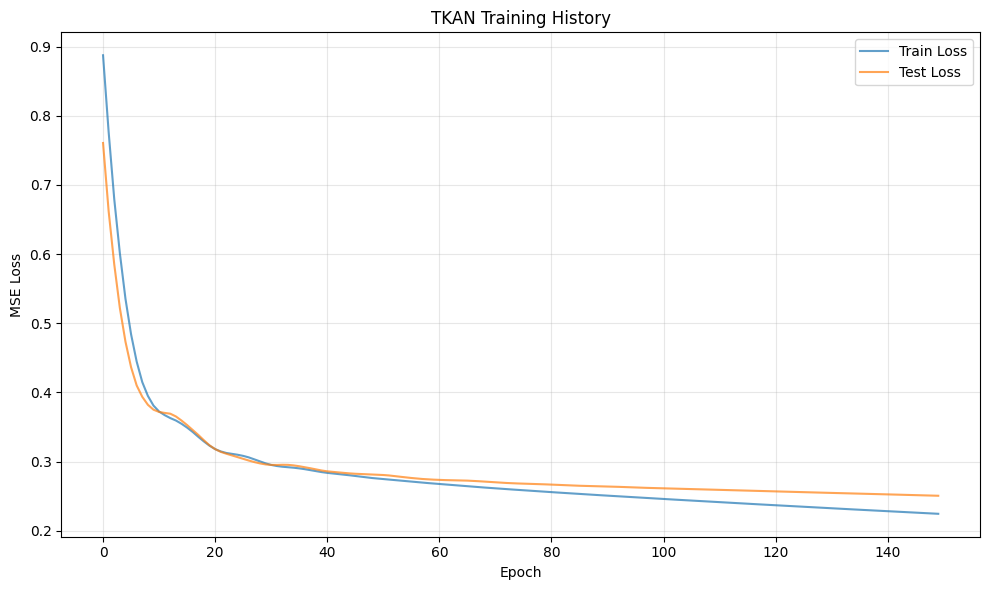

Minimum train loss: 0.224464 at epoch 150
Minimum test loss: 0.250551 at epoch 150


In [210]:
# Plot training and test loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss', alpha=0.7)
plt.plot(test_losses, label='Test Loss', alpha=0.7)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('TKAN Training History')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f'Minimum train loss: {min(train_losses):.6f} at epoch {train_losses.index(min(train_losses))+1}')
print(f'Minimum test loss: {min(test_losses):.6f} at epoch {test_losses.index(min(test_losses))+1}')

## Make Predictions

In [211]:
# Make predictions
model.eval()
with torch.no_grad():
    y_pred_train_scaled = model(X_train_tensor, temporal_train)
    y_pred_test_scaled = model(X_test_tensor, temporal_test)

# Convert to numpy and inverse transform
y_pred_train = scaler_y.inverse_transform(y_pred_train_scaled.cpu().numpy())
y_pred_test = scaler_y.inverse_transform(y_pred_test_scaled.cpu().numpy())

print('Predictions generated successfully')
print(f'Train predictions shape: {y_pred_train.shape}')
print(f'Test predictions shape: {y_pred_test.shape}')

Predictions generated successfully
Train predictions shape: (10524, 1)
Test predictions shape: (878, 1)


## Evaluation Metrics

Compute standard regression metrics:
- RMSE (Root Mean Squared Error)
- MAE (Mean Absolute Error)
- R² Score


In [212]:
# Compute metrics
def compute_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    # Normalized metrics (using range)
    y_range = y_true.max() - y_true.min()
    nrmse = rmse / y_range
    nmae = mae / y_range
    
    return {
        'rmse': rmse, 
        'mae': mae, 
        'r2': r2,
        'nrmse': nrmse,
        'nmae': nmae,
        'nrmse_pct': nrmse * 100,
        'nmae_pct': nmae * 100
    }

train_metrics = compute_metrics(y_train, y_pred_train)
test_metrics = compute_metrics(y_test, y_pred_test)

print('=' * 60)
print('TKAN Model Performance')
print('=' * 60)
print(f'\nTrain Set:')
print(f'  RMSE: {train_metrics["rmse"]:.4f}')
print(f'  MAE:  {train_metrics["mae"]:.4f}')
print(f'  NRMSE: {train_metrics["nrmse"]:.4f} ({train_metrics["nrmse_pct"]:.2f}%)')
print(f'  NMAE:  {train_metrics["nmae"]:.4f} ({train_metrics["nmae_pct"]:.2f}%)')
print(f'  R²:   {train_metrics["r2"]:.4f}')

print(f'\nTest Set:')
print(f'  RMSE: {test_metrics["rmse"]:.4f}')
print(f'  MAE:  {test_metrics["mae"]:.4f}')
print(f'  NRMSE: {test_metrics["nrmse"]:.4f} ({test_metrics["nrmse_pct"]:.2f}%)')
print(f'  NMAE:  {test_metrics["nmae"]:.4f} ({test_metrics["nmae_pct"]:.2f}%)')
print(f'  R²:   {test_metrics["r2"]:.4f}')
print('=' * 60)

TKAN Model Performance

Train Set:
  RMSE: 666.8013
  MAE:  510.0641
  NRMSE: 0.1186 (11.86%)
  NMAE:  0.0907 (9.07%)
  R²:   0.7759

Test Set:
  RMSE: 705.1264
  MAE:  536.1855
  NRMSE: 0.1264 (12.64%)
  NMAE:  0.0961 (9.61%)
  R²:   0.7424


## Visualization: Predictions vs Actual

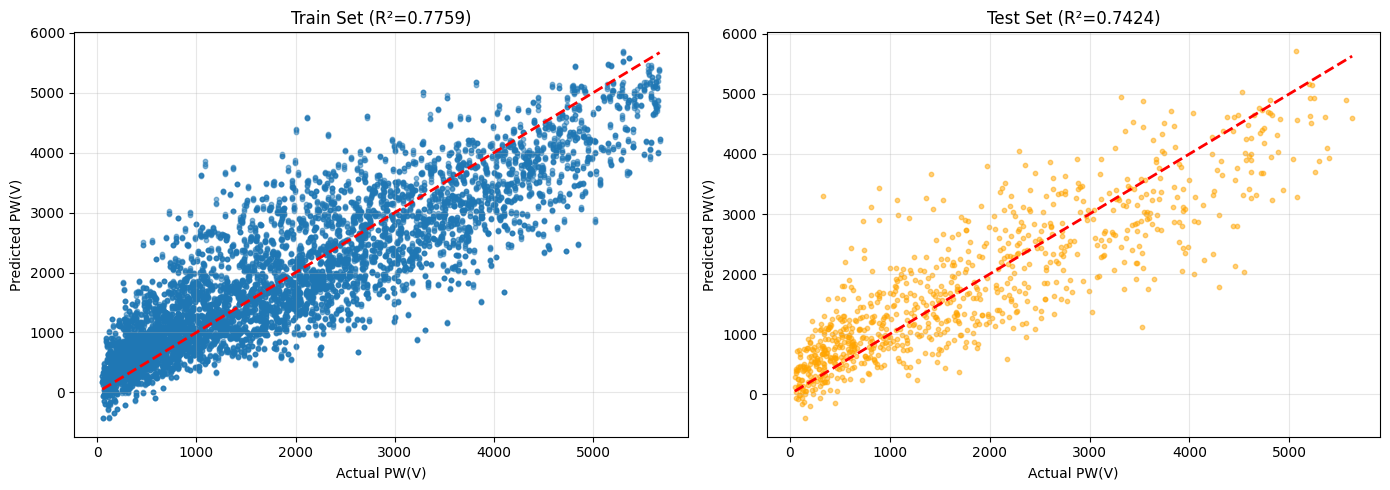

In [213]:
# Scatter plot: Predictions vs Actual
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Train set
axes[0].scatter(y_train, y_pred_train, alpha=0.5, s=10)
axes[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual PW(V)')
axes[0].set_ylabel('Predicted PW(V)')
axes[0].set_title(f'Train Set (R²={train_metrics["r2"]:.4f})')
axes[0].grid(True, alpha=0.3)

# Test set
axes[1].scatter(y_test, y_pred_test, alpha=0.5, s=10, color='orange')
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1].set_xlabel('Actual PW(V)')
axes[1].set_ylabel('Predicted PW(V)')
axes[1].set_title(f'Test Set (R²={test_metrics["r2"]:.4f})')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Residual Analysis

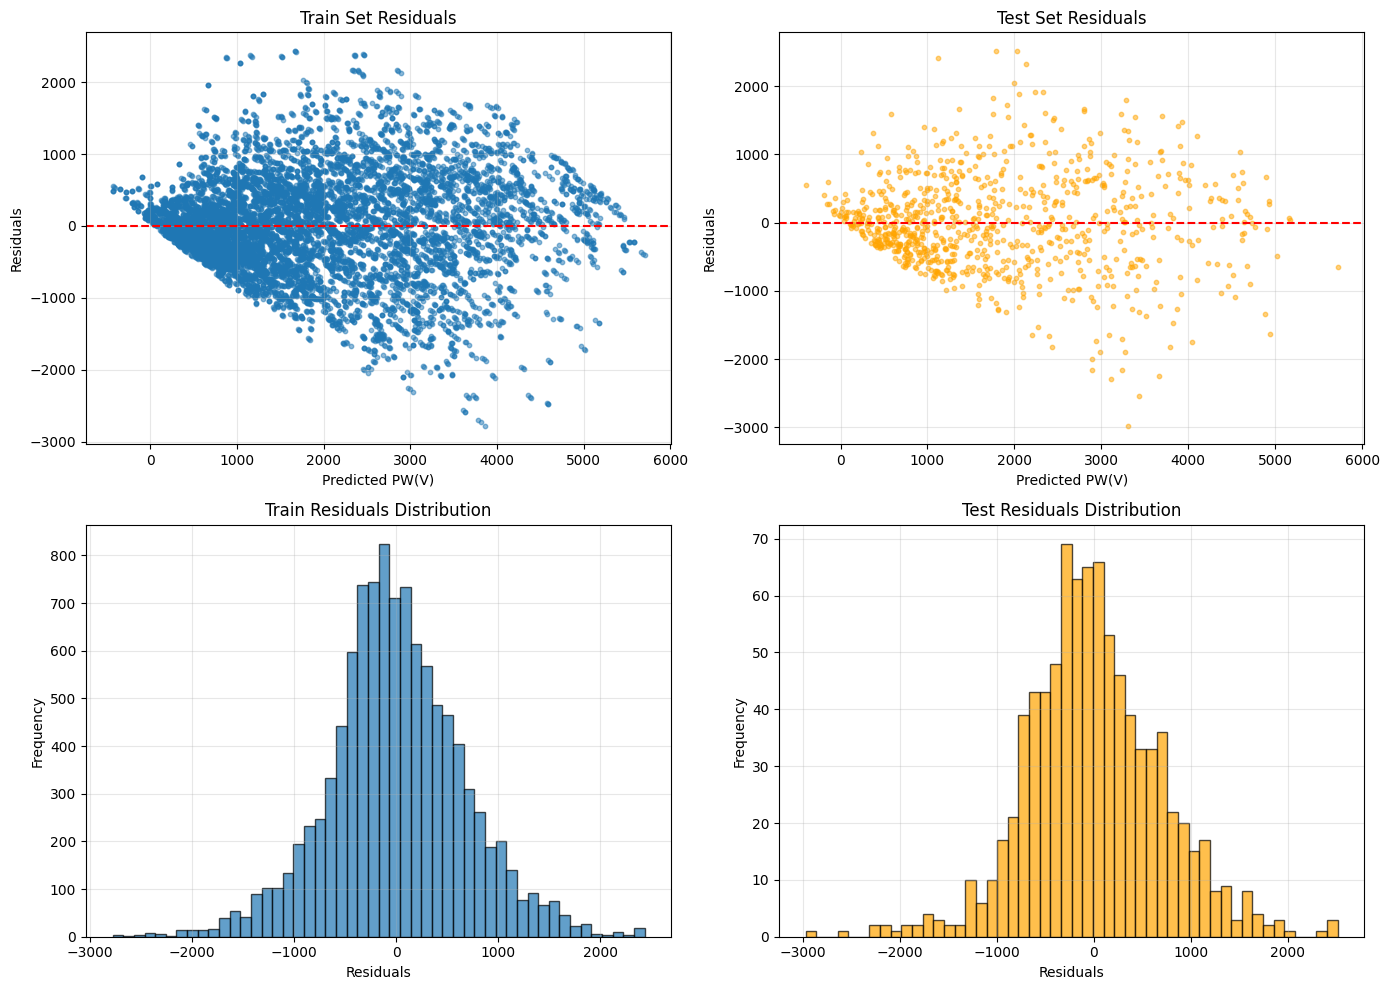

In [214]:
# Compute residuals
train_residuals = y_train.flatten() - y_pred_train.flatten()
test_residuals = y_test.flatten() - y_pred_test.flatten()

# Plot residuals
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Residuals vs Predicted
axes[0, 0].scatter(y_pred_train, train_residuals, alpha=0.5, s=10)
axes[0, 0].axhline(y=0, color='r', linestyle='--')
axes[0, 0].set_xlabel('Predicted PW(V)')
axes[0, 0].set_ylabel('Residuals')
axes[0, 0].set_title('Train Set Residuals')
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].scatter(y_pred_test, test_residuals, alpha=0.5, s=10, color='orange')
axes[0, 1].axhline(y=0, color='r', linestyle='--')
axes[0, 1].set_xlabel('Predicted PW(V)')
axes[0, 1].set_ylabel('Residuals')
axes[0, 1].set_title('Test Set Residuals')
axes[0, 1].grid(True, alpha=0.3)

# Residual histograms
axes[1, 0].hist(train_residuals, bins=50, alpha=0.7, edgecolor='black')
axes[1, 0].set_xlabel('Residuals')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Train Residuals Distribution')
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].hist(test_residuals, bins=50, alpha=0.7, edgecolor='black', color='orange')
axes[1, 1].set_xlabel('Residuals')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Test Residuals Distribution')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Save Model

In [215]:
# Save model
model_path = os.path.join(MODEL_DIR, 'tkan_model.pth')

torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_losses': train_losses,
    'test_losses': test_losses,
    'train_metrics': train_metrics,
    'test_metrics': test_metrics,
    'feature_cols': feature_cols,
    'scaler_X': scaler_X,
    'scaler_y': scaler_y
}, model_path)

print(f'Model saved to: {model_path}')

Model saved to: c:\Users\cw171001\OneDrive - Teradata\Documents\GitHub\PFDA-programming-for-data-analytics\big_project\model\tkan_model.pth


## Summary

### What We Did:

1. **Implemented TKAN** - A Temporal KAN using pure PyTorch
2. **Temporal Encoding** - Extracted hour, day_of_week, day_of_year, month from DateTime column
3. **Sinusoidal Embeddings** - Encoded temporal features as sin/cos functions
4. **Learnable Activations** - Used RBF kernels for KAN's characteristic learnable functions
5. **Training** - Trained with MSE loss + L1 regularization
6. **Evaluation** - Computed RMSE, MAE, R² metrics

### Key Differences from Efficient KAN:

- **Explicit temporal encoding**: TKAN uses DateTime column explicitly
- **Sinusoidal embeddings**: Similar to positional encoding in Transformers
- **Both use PyTorch**: This eliminates Keras/TensorFlow dependency
- **RBF-based KAN**: Simpler than B-splines but captures similar patterns

### Next Steps:

- Compare with Efficient KAN results
- Try different temporal_dim values (8, 16, 32)
- Experiment with grid_size
- Add more hidden layers
- Use chronological split for more realistic evaluation
